# Killing Capacity for Multi Cell Cytotoxicity

As far as we have observed the cytotoxicity events, cross cell killing event happens as a collaborative effort of multiple contacts. Without the application of signaling markers (e.g. CD107 degranulations or CD95/CD95L Fas/L), we may only define the killing capacity by the viability expression level (e.g. Cell Death Index). In this notebook we deploy the concept of forward killing capacity to profile the collective cytotoxicity ability.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

## Data Generation
For demonstration purpose, we generate 50 killer cells and 100 target pathogens over 200 time frames

In [2]:
def generate_killer_cell_data_frame_ids(num_cells, num_pathogens, num_frames):
    """
    Simulate killer cell data with frame IDs instead of timestamps.
    
    Parameters:
        num_cells (int): Number of killer cells.
        num_pathogens (int): Number of pathogens.
        num_frames (int): Total number of frames in the observation.
    
    Returns:
        pd.DataFrame: Killer cell data with frame IDs.
    """
    data = []
    for cell_id in range(1, num_cells + 1):
        for frame_id in range(num_frames):
            # Randomly select 1-5 pathogens for each killer cell at each frame
            target_ids = random.sample(range(1, num_pathogens + 1), k=random.randint(1, 5))
            data.append({
                'killer_cell_id': cell_id,
                'frame_id': frame_id,
                'current_target_ids': target_ids
            })
    return pd.DataFrame(data)

In [3]:
def generate_pathogen_data_frame_ids(num_pathogens, num_frames):
    """
    Simulate pathogen cell death index data with frame IDs instead of timestamps.
    
    Parameters:
        num_pathogens (int): Number of pathogens.
        num_frames (int): Total number of frames in the observation.
    
    Returns:
        pd.DataFrame: Pathogen data with frame IDs.
    """
    data = []
    for pathogen_id in range(1, num_pathogens + 1):
        cdi = 100
        for frame_id in range(num_frames):
            # Add noise and a trend
            cdi = max(0, cdi - random.uniform(0.1, 0.5) + random.gauss(0, 2))
            data.append({
                'id': pathogen_id,
                'frame_id': frame_id,
                'current_cdi': 1 - cdi/100
            })
    return pd.DataFrame(data)

In [4]:
# Example: 50 Killer Cells, 100 Pathogens, 360 Frames (1 Hour @ 0.1 FPS)
num_killer_cells = 50
num_pathogens = 100
num_frames = 360

killer_cell_df = generate_killer_cell_data_frame_ids(num_killer_cells, num_pathogens, num_frames)
pathogen_df = generate_pathogen_data_frame_ids(num_pathogens, num_frames)

In [5]:
killer_cell_df

,killer_cell_id,frame_id,current_target_ids
0,1,0,"[33, 29, 88]"
1,1,1,"[79, 4]"
2,1,2,"[37, 6, 60, 93]"
3,1,3,"[90, 56, 42, 46, 35]"
4,1,4,"[14, 78]"
...,...,...,...
17995,50,355,[50]
17996,50,356,"[25, 12, 72, 14, 95]"
17997,50,357,"[82, 90, 73, 7]"
17998,50,358,"[52, 20, 24]"


In [6]:
pathogen_df

,id,frame_id,current_cdi
0,1,0,0.033140
1,1,1,0.049058
2,1,2,0.074406
3,1,3,0.109325
4,1,4,0.067585
...,...,...,...
35995,100,355,0.991609
35996,100,356,1.000000
35997,100,357,1.000000
35998,100,358,1.000000


In [7]:
def calculate_accumulated_contacts(killer_cell_df, num_pathogens, num_frames):
    """
    Calculate the accumulated contact count for each killer cell and frame.
    
    Parameters:
        killer_cell_df (pd.DataFrame): Initial killer cell data with columns 
                                       ['killer_cell_id', 'frame_id', 'current_target_ids'].
        num_pathogens (int): Total number of pathogens.
        num_frames (int): Total number of frames.
    
    Returns:
        pd.DataFrame: Killer cell data with updated accumulated contact count.
    """
    # Initialize accumulated contacts
    contact_counts = {cell_id: [0] * num_pathogens for cell_id in killer_cell_df['killer_cell_id'].unique()}

    updated_rows = []

    for frame_id in range(num_frames):
        # Filter killer cells for the current frame
        current_frame_data = killer_cell_df[killer_cell_df['frame_id'] == frame_id]

        for _, row in current_frame_data.iterrows():
            killer_id = row['killer_cell_id']
            target_ids = row['current_target_ids']

            # Update contact count for each target pathogen
            for target_id in target_ids:
                contact_counts[killer_id][target_id - 1] += 1

            # Accumulate total contacts for this killer cell
            accumulated_count = sum(contact_counts[killer_id])

            # Update row
            updated_rows.append({
                'killer_cell_id': killer_id,
                'frame_id': frame_id,
                'accumulated_contact_count': accumulated_count,
                'current_target_ids': target_ids
            })

    return pd.DataFrame(updated_rows)

In [8]:
# Calculate Accumulated Contacts
killer_cell_df = calculate_accumulated_contacts(killer_cell_df, num_pathogens, num_frames)

In [9]:
killer_cell_df

,killer_cell_id,frame_id,accumulated_contact_count,current_target_ids
0,1,0,3,"[33, 29, 88]"
1,2,0,2,"[72, 10]"
2,3,0,4,"[45, 12, 72, 49]"
3,4,0,2,"[71, 48]"
4,5,0,2,"[24, 48]"
...,...,...,...,...
17995,46,359,1118,"[31, 42]"
17996,47,359,1093,"[34, 18, 30]"
17997,48,359,1081,"[67, 88, 9, 94, 16]"
17998,49,359,1073,[5]


## Quick Data Examination

### Pathogen Viability

In [10]:
def smooth_cdi(pathogen_df, window_size=3):
    """
    Smooth the CDI data using a rolling mean to reduce noise.
    
    Parameters:
        pathogen_df (pd.DataFrame): Pathogen data with ['id', 'time', 'current_viability'] columns.
        window_size (int): Window size for rolling average smoothing.
    
    Returns:
        pd.DataFrame: DataFrame with smoothed viability values.
    """
    pathogen_df = pathogen_df.sort_values(by=['id', 'frame_id'])
    pathogen_df['smoothed_cdi'] = (
        pathogen_df.groupby('id')['current_cdi']
        .transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())
    )
    return pathogen_df

In [11]:
# Smooth Viability Data
pathogen_df = smooth_cdi(pathogen_df, window_size=10)
pathogen_df

,id,frame_id,current_cdi,smoothed_cdi
0,1,0,0.033140,0.033140
1,1,1,0.049058,0.041099
2,1,2,0.074406,0.052201
3,1,3,0.109325,0.066482
4,1,4,0.067585,0.066703
...,...,...,...,...
35995,100,355,0.991609,0.988045
35996,100,356,1.000000,0.993887
35997,100,357,1.000000,0.997255
35998,100,358,1.000000,0.999161


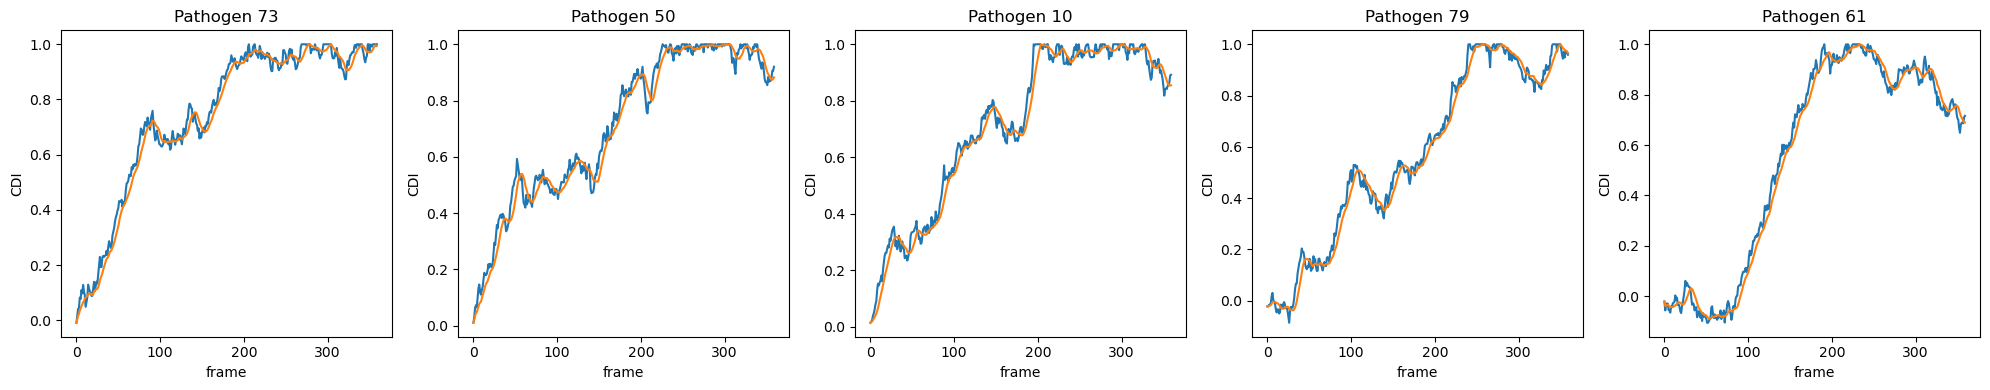

In [12]:
fig, axs = plt.subplots(1,5,figsize=(20,4))
pathogen_ids = [int(i) for i in np.random.rand(5)*100]

for id, ax in zip(pathogen_ids,axs):
    ax.set_title("Pathogen {}".format(id))
    cell = pathogen_df[pathogen_df['id'] == id]
    ax.plot(cell["frame_id"],cell["current_cdi"])
    ax.plot(cell["frame_id"],cell["smoothed_cdi"])
    ax.set_xlabel("frame")
    ax.set_ylabel("CDI")

fig.tight_layout()

### Killer Cell Contacts

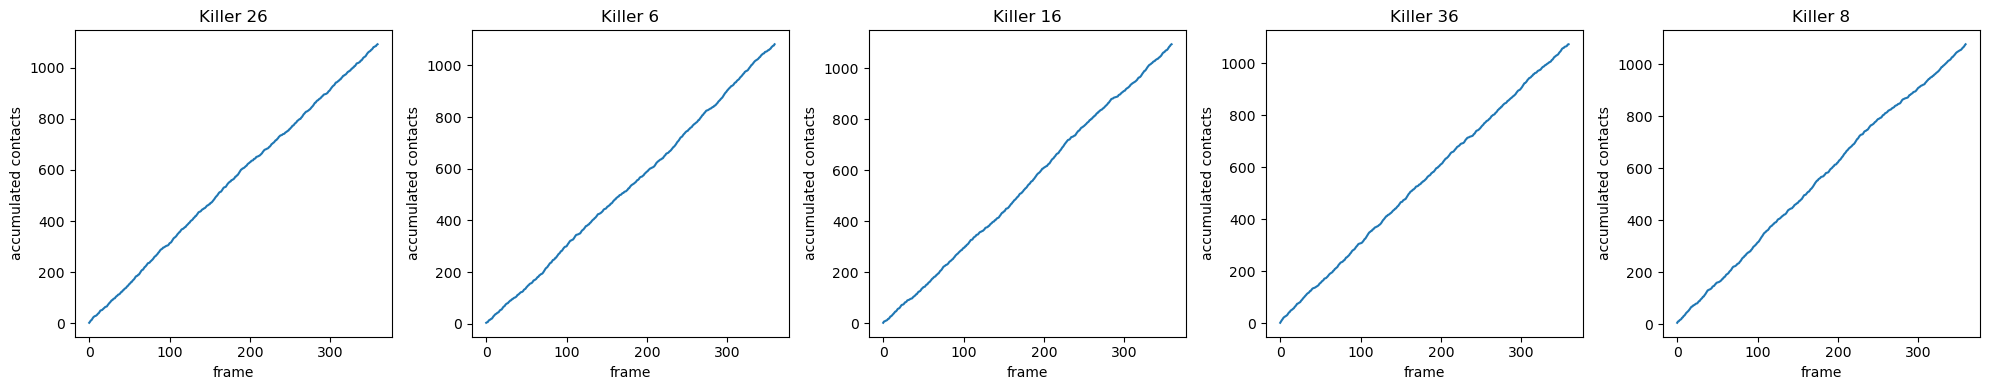

In [13]:
fig, axs = plt.subplots(1,5,figsize=(20,4))
killer_ids = [int(i) for i in np.random.rand(5)*num_killer_cells]

for id, ax in zip(killer_ids,axs):
    ax.set_title("Killer {}".format(id))
    cell = killer_cell_df[killer_cell_df['killer_cell_id'] == id]
    ax.plot(cell["frame_id"],cell["accumulated_contact_count"])
    ax.set_xlabel("frame")
    ax.set_ylabel("accumulated contacts")

fig.tight_layout()

### Perform Analyze on Collaborative Killings

The collaborative killing capacity can be expressed mathematically as a weighted contribution of multiple killer cells targeting the same pathogen. Here’s how we can formalize it:

#### Collaborative Killing Capacity
1. **Individual Pathogen Killing Contribution**

    The killing capacity $\text{KC}_{ij}$ of killer cell $K_i$ for pathogen $P_j$ over a forward projection window $\Delta t$ (e.g., 30 minutes or 180 frames) is defined as:

    $$
    \text{KC}_{ij} = \frac{V_j(t+\Delta t)-V_j(t)}{V_j(t)}\times 100\%
    $$

    This represents the percentage increment in viability of targeted pathogen/cell $P_j$ caused by the interactions.

2. **Collaborative Weighting**
    
    If $P_j$ is targeted by multiple killer cells, the contribution of $K_i$ is weighted by $W_i(t)$, where:

    $$
    W_{ij}=\frac{C_{ij}(t)}{\sum_{k\in\mathscr{K_j}}C_{kj}(t)}
    $$
    
    where
    - $\mathscr{K_j}$ is the set of all killer cells interacting with at time $t$; and
    - The weight $W_{ij}(t)$ reflects the fraction of contact $K_i$ contributes relative to all killers targeting $P_j$.

3. **Overall Killing Capacity for $K_i$**
    
    The overall killing capacity of killer $K_i$ is then computed as the weighted sum of its contributions across all pathogens it targets:

    $$
    \text{KC}_i(t) = \sum_{j\in\mathscr{P_i}}W_{ij}(t)\cdot\text{KC}_{ij}
    $$

    where $P_i$ is the set of pathogen targeted by $K_i$ at time $t$

#### Intuition
1. **Killing Contribution**: $\text{KC}_{ij}$ measures the pathogen-specific killing ability of a killer cell, while $W_{ij}(t)$ accounts for shared responsibility when multiple killers target the same pathogen.
2. **Collaborative Effect**: The weighting ensures that each killer cell's impact is proportional to its relative involvement.

#### Notations
Let:
- $P_j$:Pathogen 
- $K_i$:Killer cell 
- $V_j(t)$: Viability of pathogen at time (or frame) $t$, in range $[0,1]$ where higher represents more viable. Corresponding to $1-\text{Cell Death Index}$
- $W_{ij}(t)$: Weight of killer cell $i$ contributing to the killing of pathogen $j$ at time $t$. This reflects the collaborative effect when multiple killer cells target the same pathogen.
- $C_{ij}(t)$: Contact count between killer cell $i$ and pathogen $j$ at time $t$.

#### Noise Tolerance
1. **Zero Floor for Killing Capacity**

    If the CDI percentage change decreases with time (e.g., $V_j(t+\Delta t) < V_j(t)V$), we can cap the floor killing capacity at zero. This assumes that an increase in CDI is due to noise and does not represent actual pathogen recovery.

    $$
    \text{KC}_{ij} = \max\left(0,\frac{V_j(t+\Delta t)-V_j(t)}{V_j(t)}\times 100\%\right)
    $$

    This ensures killing capacity is always non-negative.

2. **Normalize Killing Capacity**
    
    Normalize killing capacity by accounting for noise thresholds:

    $$
    \text{KC}_{ij}=\frac{\max\left(0,V_j(t+\Delta t)-V_j(t)-\epsilon\right)}{V_j(t)}\times 100\%
    $$
    
    Where $\epsilon$ is a small positive value representing acceptable noise in viability measurements.

In [17]:
def analyze_collaborative_killing_capacity_frame_ids(killer_cell_df, pathogen_df, killer_ids, projection_frames=180, noise_threshold=2.0, projection_method="last"):
    """
    Analyze collaborative killing capacity using frame IDs as the time reference.
    
    Parameters:
        killer_cell_df (pd.DataFrame): Killer cell data with columns ['killer_cell_id', 'frame_id', 'accumulated_contact_count', 'current_target_ids'].
        pathogen_df (pd.DataFrame): Pathogen data with columns ['id', 'frame_id', 'current_viability', 'smoothed_viability'].
        projection_frames (int): Number of frames in the projection window (e.g., 30 frames for 30 minutes).
        projection_method (str): Method to generate the projection value, string options of ['last','90ptile','mean'], default='last'
        noise_threshold (float): Minimum viability change to consider meaningful (filters noise).
    
    Returns:
        pd.DataFrame: Collaborative killing capacity results for each killer cell.
    """
    results = []

    for killer_id in tqdm(killer_ids):
        # filter out single killer cell
        killer = killer_cell_df[killer_cell_df["killer_cell_id"] == killer_id]

        for _, killer_row in killer.iterrows():
            current_frame = killer_row['frame_id']
            target_ids = killer_row['current_target_ids']

            # Filter pathogens currently contacted by this killer cell
            target_pathogens = pathogen_df[pathogen_df['id'].isin(target_ids)]

            initial_viability = []
            subsequent_viability = []
            collaborative_weights = []

            for target_id in target_ids:
                # Filter pathogen data for this specific target
                pathogen_data = target_pathogens[target_pathogens['id'] == target_id]
                initial_v = pathogen_data.loc[pathogen_data['frame_id'] == current_frame, 'smoothed_cdi']

                # Ensure viability data is available
                if initial_v.empty:
                    continue

                # Find viability in the next projection_frames
                future_data = pathogen_data[
                    (pathogen_data['frame_id'] > current_frame) &
                    (pathogen_data['frame_id'] <= current_frame + projection_frames)
                ]

                if projection_method in ["last","90ptile"]:
                    initial_v = initial_v.iloc[0]
                elif projection_method == "mean":
                    if not future_data.empty:
                        smoothed_cdi = future_data['smoothed_cdi']
                        initial_v = np.mean(smoothed_cdi[smoothed_cdi>np.percentile(smoothed_cdi,10)])
                    else:
                        initial_v = initial_v.iloc[0]
                else:
                    raise NotImplementedError("projection_method {} not implemented".format(projection_method)) 

                if not future_data.empty:
                    if projection_method == "last":
                        projected_v = future_data['smoothed_cdi'].iloc[-1]
                    elif projection_method == "90ptile":
                        projected_v = np.percentile(future_data['smoothed_cdi'],90)
                    elif projection_method == "mean":
                        smoothed_cdi = future_data['smoothed_cdi']
                        projected_v = np.mean(smoothed_cdi[smoothed_cdi>np.percentile(smoothed_cdi,90)])
                    else:
                        raise NotImplementedError("projection_method {} not implemented".format(projection_method))
                else:
                    projected_v = initial_v

                # Determine collaborative killers
                overlapping_killers = killer_cell_df[
                    (killer_cell_df['frame_id'] == current_frame) &
                    (killer_cell_df['current_target_ids'].apply(lambda x: target_id in x))
                ]
                num_collaborators = len(overlapping_killers)

                # Assign equal weight to each killer for this pathogen
                weight = 1 / num_collaborators if num_collaborators > 0 else 1

                initial_viability.append(initial_v)
                subsequent_viability.append(projected_v)
                collaborative_weights.append(weight)

            # Compute weighted killing capacity for this killer cell
            initial_viability = np.array(initial_viability)
            subsequent_viability = np.array(subsequent_viability)
            collaborative_weights = np.array(collaborative_weights)

            killing_capacity = ((initial_viability - subsequent_viability) / initial_viability) * 100
            killing_capacity = np.maximum(killing_capacity - noise_threshold, 0)  # Correct for noise
            weighted_killing_capacity = np.nanmean(killing_capacity * collaborative_weights)

            results.append({
                'killer_cell_id': killer_id,
                'frame_id': current_frame,
                'killing_capacity': weighted_killing_capacity
            })

    # Convert results to DataFrame
    return pd.DataFrame(results)

In [22]:
# Analyze Collaborative Killing Capacity with Frame IDs
collaborative_results = analyze_collaborative_killing_capacity_frame_ids(killer_cell_df, pathogen_df, killer_ids, projection_frames=30, projection_method="mean")
collaborative_results

  0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipykernel_4043596/3387283382.py:92: RuntimeWarning: Mean of empty slice
  weighted_killing_capacity = np.nanmean(killing_capacity * collaborative_weights)
100%|██████████| 5/5 [00:15<00:00,  3.01s/it]


,killer_cell_id,frame_id,killing_capacity
0,26,0,0.000000
1,26,1,41.743391
2,26,2,64.605280
3,26,3,18.461631
4,26,4,15.459356
...,...,...,...
1795,8,355,0.000000
1796,8,356,0.000000
1797,8,357,0.000000
1798,8,358,NaN


### Plot the Killing Capacities

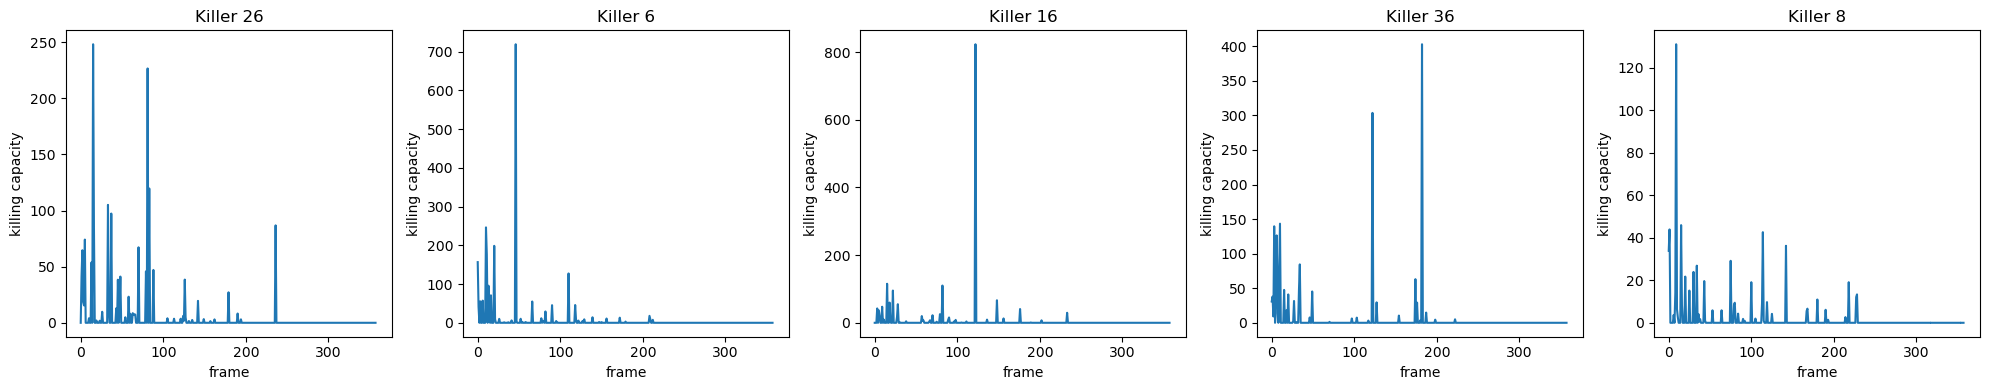

In [23]:
fig, axs = plt.subplots(1,5,figsize=(20,4))

for id, ax in zip(killer_ids,axs):
    ax.set_title("Killer {}".format(id))
    cell = collaborative_results[collaborative_results['killer_cell_id'] == id]
    ax.plot(cell["frame_id"],cell["killing_capacity"])
    ax.set_xlabel("frame")
    ax.set_ylabel("killing capacity")

fig.tight_layout()